In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
input_size = 28 * 28
hidden_size = 600
num_classes = 10
num_epochs = 10
batch_size = 100
drop_prob = 0.2
weight_decay_lambda = 0.01
learning_rate = 0.001

만약에 같은 비율로 쪼개고 싶으면 sklearn에서 미리 전처리

In [5]:
train_dev_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
train_dataset, dev_dataset = torch.utils.data.random_split(train_dev_dataset, [50000,10000])

In [7]:
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor())

In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False)

In [13]:
def evalutaion(data_loader):
  correct = 0
  total = 0
  for images, labels in data_loader:
    images = images.reshape(-1,28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  return correct / total

In [15]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, num_classes):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    torch.nn.init.kaiming_normal_(self.fc1.weight) # he_normal
    torch.nn.init.zeros_(self.fc1.bias)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    torch.nn.init.kaiming_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc2.bias)
    self.fc3 = nn.Linear(hidden_size, num_classes)
    torch.nn.init.kaiming_normal_(self.fc3.weight) # he_normal
    torch.nn.init.zeros_(self.fc3.bias)
    self.dropout = nn.Dropout(drop_prob)
  
  def forward(self, x):
    out = F.relu(self.fc1(x))
    out = self.dropout(out)
    out = F.relu(self.fc2(out))
    out = self.dropout(out)
    out = self.fc3(out)
    return out

In [16]:
model = NeuralNet(input_size, num_classes).to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay_lambda)

In [18]:
loss_arr = []
max = 0
total_step = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.reshape(-1,28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % 100 == 0:
      loss_arr.append(loss)
      print('epoch [{}/{}], Step [{}/{}], Loss : {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

      with torch.no_grad():
        model.eval()
        acc = evalutaion(dev_loader)
        if max < acc:
          max = acc
          print("max dev accuracy : ", max)
          torch.save(model.state_dict(), "model.ckpt") # early stopping

epoch [1/10], Step [100/500], Loss : 0.4962
max dev accuracy :  0.9027
epoch [1/10], Step [200/500], Loss : 0.2403
max dev accuracy :  0.9215
epoch [1/10], Step [300/500], Loss : 0.3189
max dev accuracy :  0.9235
epoch [1/10], Step [400/500], Loss : 0.2430
max dev accuracy :  0.932
epoch [1/10], Step [500/500], Loss : 0.3108
epoch [2/10], Step [100/500], Loss : 0.2164
max dev accuracy :  0.936
epoch [2/10], Step [200/500], Loss : 0.3560
epoch [2/10], Step [300/500], Loss : 0.2439
epoch [2/10], Step [400/500], Loss : 0.4219
epoch [2/10], Step [500/500], Loss : 0.2150
epoch [3/10], Step [100/500], Loss : 0.2797
max dev accuracy :  0.9361
epoch [3/10], Step [200/500], Loss : 0.2785
max dev accuracy :  0.938
epoch [3/10], Step [300/500], Loss : 0.2699
epoch [3/10], Step [400/500], Loss : 0.2423
max dev accuracy :  0.9406
epoch [3/10], Step [500/500], Loss : 0.2540
epoch [4/10], Step [100/500], Loss : 0.1504
epoch [4/10], Step [200/500], Loss : 0.2036
max dev accuracy :  0.9426
epoch [4/10]

accuracy of the network on the 10000 test images : 94.27%


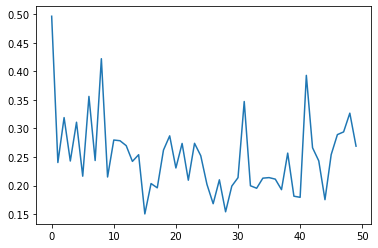

In [20]:
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.reshape(-1,28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("accuracy of the network on the 10000 test images : {}%".format(100 * correct / total))
torch.save(model.state_dict, "model.ckpt")
plt.plot(loss_arr)
plt.show()